# Lesson 13, Workalong 02: Plotting geospatial data

This workalong shows how to use `rioxarray` to read a raster file (a GeoTIFF in this case) to add topography to our plot.  It also shows some tricks for getting good-looking topo plots.

In [1]:
""" Import libraries """
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib as mpl
import rioxarray
import cartopy
import numpy as np
import cmocean

mpl.style.use('seaborn-v0_8-poster')

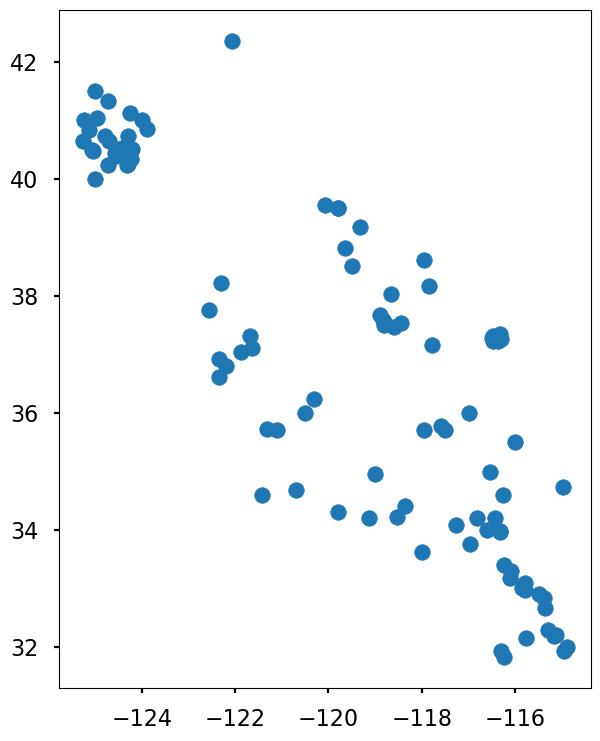

In [2]:
""" Load the earthquake data from the earlier exercise. """

data_file = "ca_earthquakes.shp.zip"

# Load the data into a GeoDataFrame
ca_earthquakes_gdf = gpd.read_file(data_file)
ca_earthquakes_gdf.plot();


In [3]:
""" Load the topo / bathymetry data. """

# set the filepath
topo_bathy_path = "https://github.com/taobrienlbl/advanced_earth_science_data_analysis/raw/09188e9e6a0cf230f8473c0ae95d2e1b9079df3a/lessons/13_geospatial_intro/data/western_us_topo_bathy_subset.tiff"

# Load the data with rasterio
topo_bathy_rxr = rioxarray.open_rasterio(topo_bathy_path)
topo_bathy_rxr

<xarray.DataArray (band: 1, y: 673, x: 703)>
[473119 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -126.6 -126.5 -126.5 ... -114.9 -114.9 -114.9
  * y            (y) float64 43.81 43.79 43.78 43.76 ... 32.66 32.64 32.63 32.61
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:    Area
    DataType:         Generic
    SourceBandIndex:  0
    scale_factor:     1.0
    add_offset:       0.0

In [4]:
""" Load the state boundary data. """
ca_shapefile_path = "ca_inflated.shp.zip"
ca_shapefile_gdf = gpd.read_file(ca_shapefile_path)

/Users/evan/micromamba/envs/easg690/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


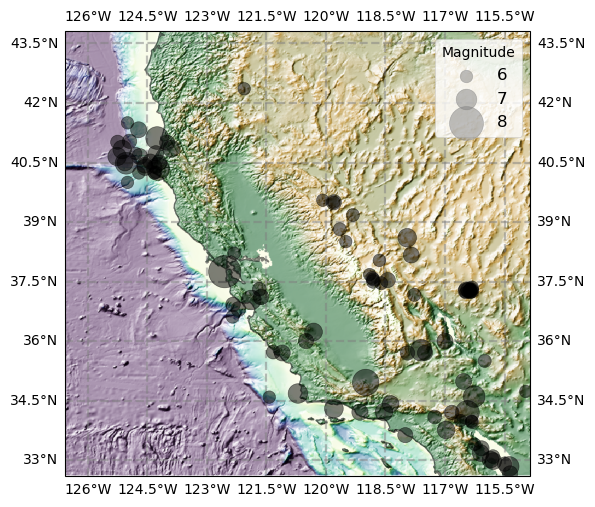

In [5]:
""" Generate a plot of earthquake locations on top of the topography / bathymetry data. """

projection = cartopy.crs.PlateCarree(central_longitude=-120)

fig, ax = plt.subplots(figsize = (6,6), subplot_kw={"projection": projection})

# ****************
# topo hillshade
# ****************
# set the light source for the hillshade
ls = mpl.colors.LightSource(azdeg=315, altdeg=45)

# convert the topo data to this projection
ax_proj = ax.projection.proj4_init
topo_bathy_rxr_proj = topo_bathy_rxr #.rio.reproject(ax_proj)

# get the x and y grid spacing
dx = abs(topo_bathy_rxr.x[1] - topo_bathy_rxr.x[0])
dy = abs(topo_bathy_rxr.y[1] - topo_bathy_rxr.y[0])
# convert the grid spacing from degrees to meters
rearth = 6371000  # in meters
dx_meters = float(np.deg2rad(dx) * rearth * np.cos(np.deg2rad(topo_bathy_rxr.y[0])))
dy_meters = float(np.deg2rad(dy) * rearth)

# generate a blended hillshade
blend = ls.shade(
    topo_bathy_rxr_proj.values.squeeze(),
    cmap=cmocean.cm.topo,
    vmin = -3000, vmax = 3000,
    blend_mode="hsv",
    dx=dx_meters, dy=dy_meters,
    vert_exag=10,
    )

# plot the hillshade
left, bottom, right, top = topo_bathy_rxr_proj.rio.bounds()
extent = [left, right, bottom, top]

ax.set_extent(extent, crs=cartopy.crs.PlateCarree())

ax.imshow(blend, cmap="Greys", extent=extent, transform=cartopy.crs.PlateCarree(), zorder=0)


# ****************
# earthquakes
# ****************
# convert the earthquake data to this projection
ca_earthquakes_gdf_proj = ca_earthquakes_gdf.to_crs(ax_proj)
# plot the earthquake locations with magnitude proportional to size
ca_earthquakes_gdf_proj.plot(
    ax = ax,
    color = "black",
    markersize = np.exp(ca_earthquakes_gdf_proj.mag)/5,
    zorder = 10,
    alpha = 0.5,
    )

# create a legend for the marker sizes
# set the marker sizes
sizes = [6, 7, 8]
# convert the sizes to the radii used in the plot
exp_sizes = np.exp(sizes)/5
labels = [f"{s}" for s in sizes]
# generate a plot that doesn't show any data; this is just so we can create a legend
handles = [plt.scatter([],[], s=s, color="gray", alpha=0.5) for s in exp_sizes]
# create the legend
leg = ax.legend(handles, labels, title="Magnitude", loc="upper right", fontsize=12)

# ****************
# geographic features
# ****************
# gridlines
gl = ax.gridlines(draw_labels=True, color="gray", alpha=0.5, linestyle="--")
ax.coastlines(resolution="10m", color="black", linewidth=1, alpha = 0.5)

# set the extent
plt.show()

grdimage [ERROR]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdimage [ERROR]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdimage (gmtlib_read_grd_info): Use grdedit -A on your grid file to make region and increments compatible [western_us_topo_bathy_subset.tiff]
grdimage [ERROR]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdimage [ERROR]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdimage (gmtlib_read_grd_info): Use grdedit -A on your grid file to make region and increments compatible [western_us_topo_bathy_subset.tiff]
grdgradient [ERROR]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdgradient [ERROR]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdgradient (gmtlib_read_grd_info): Use grdedit -A on your g

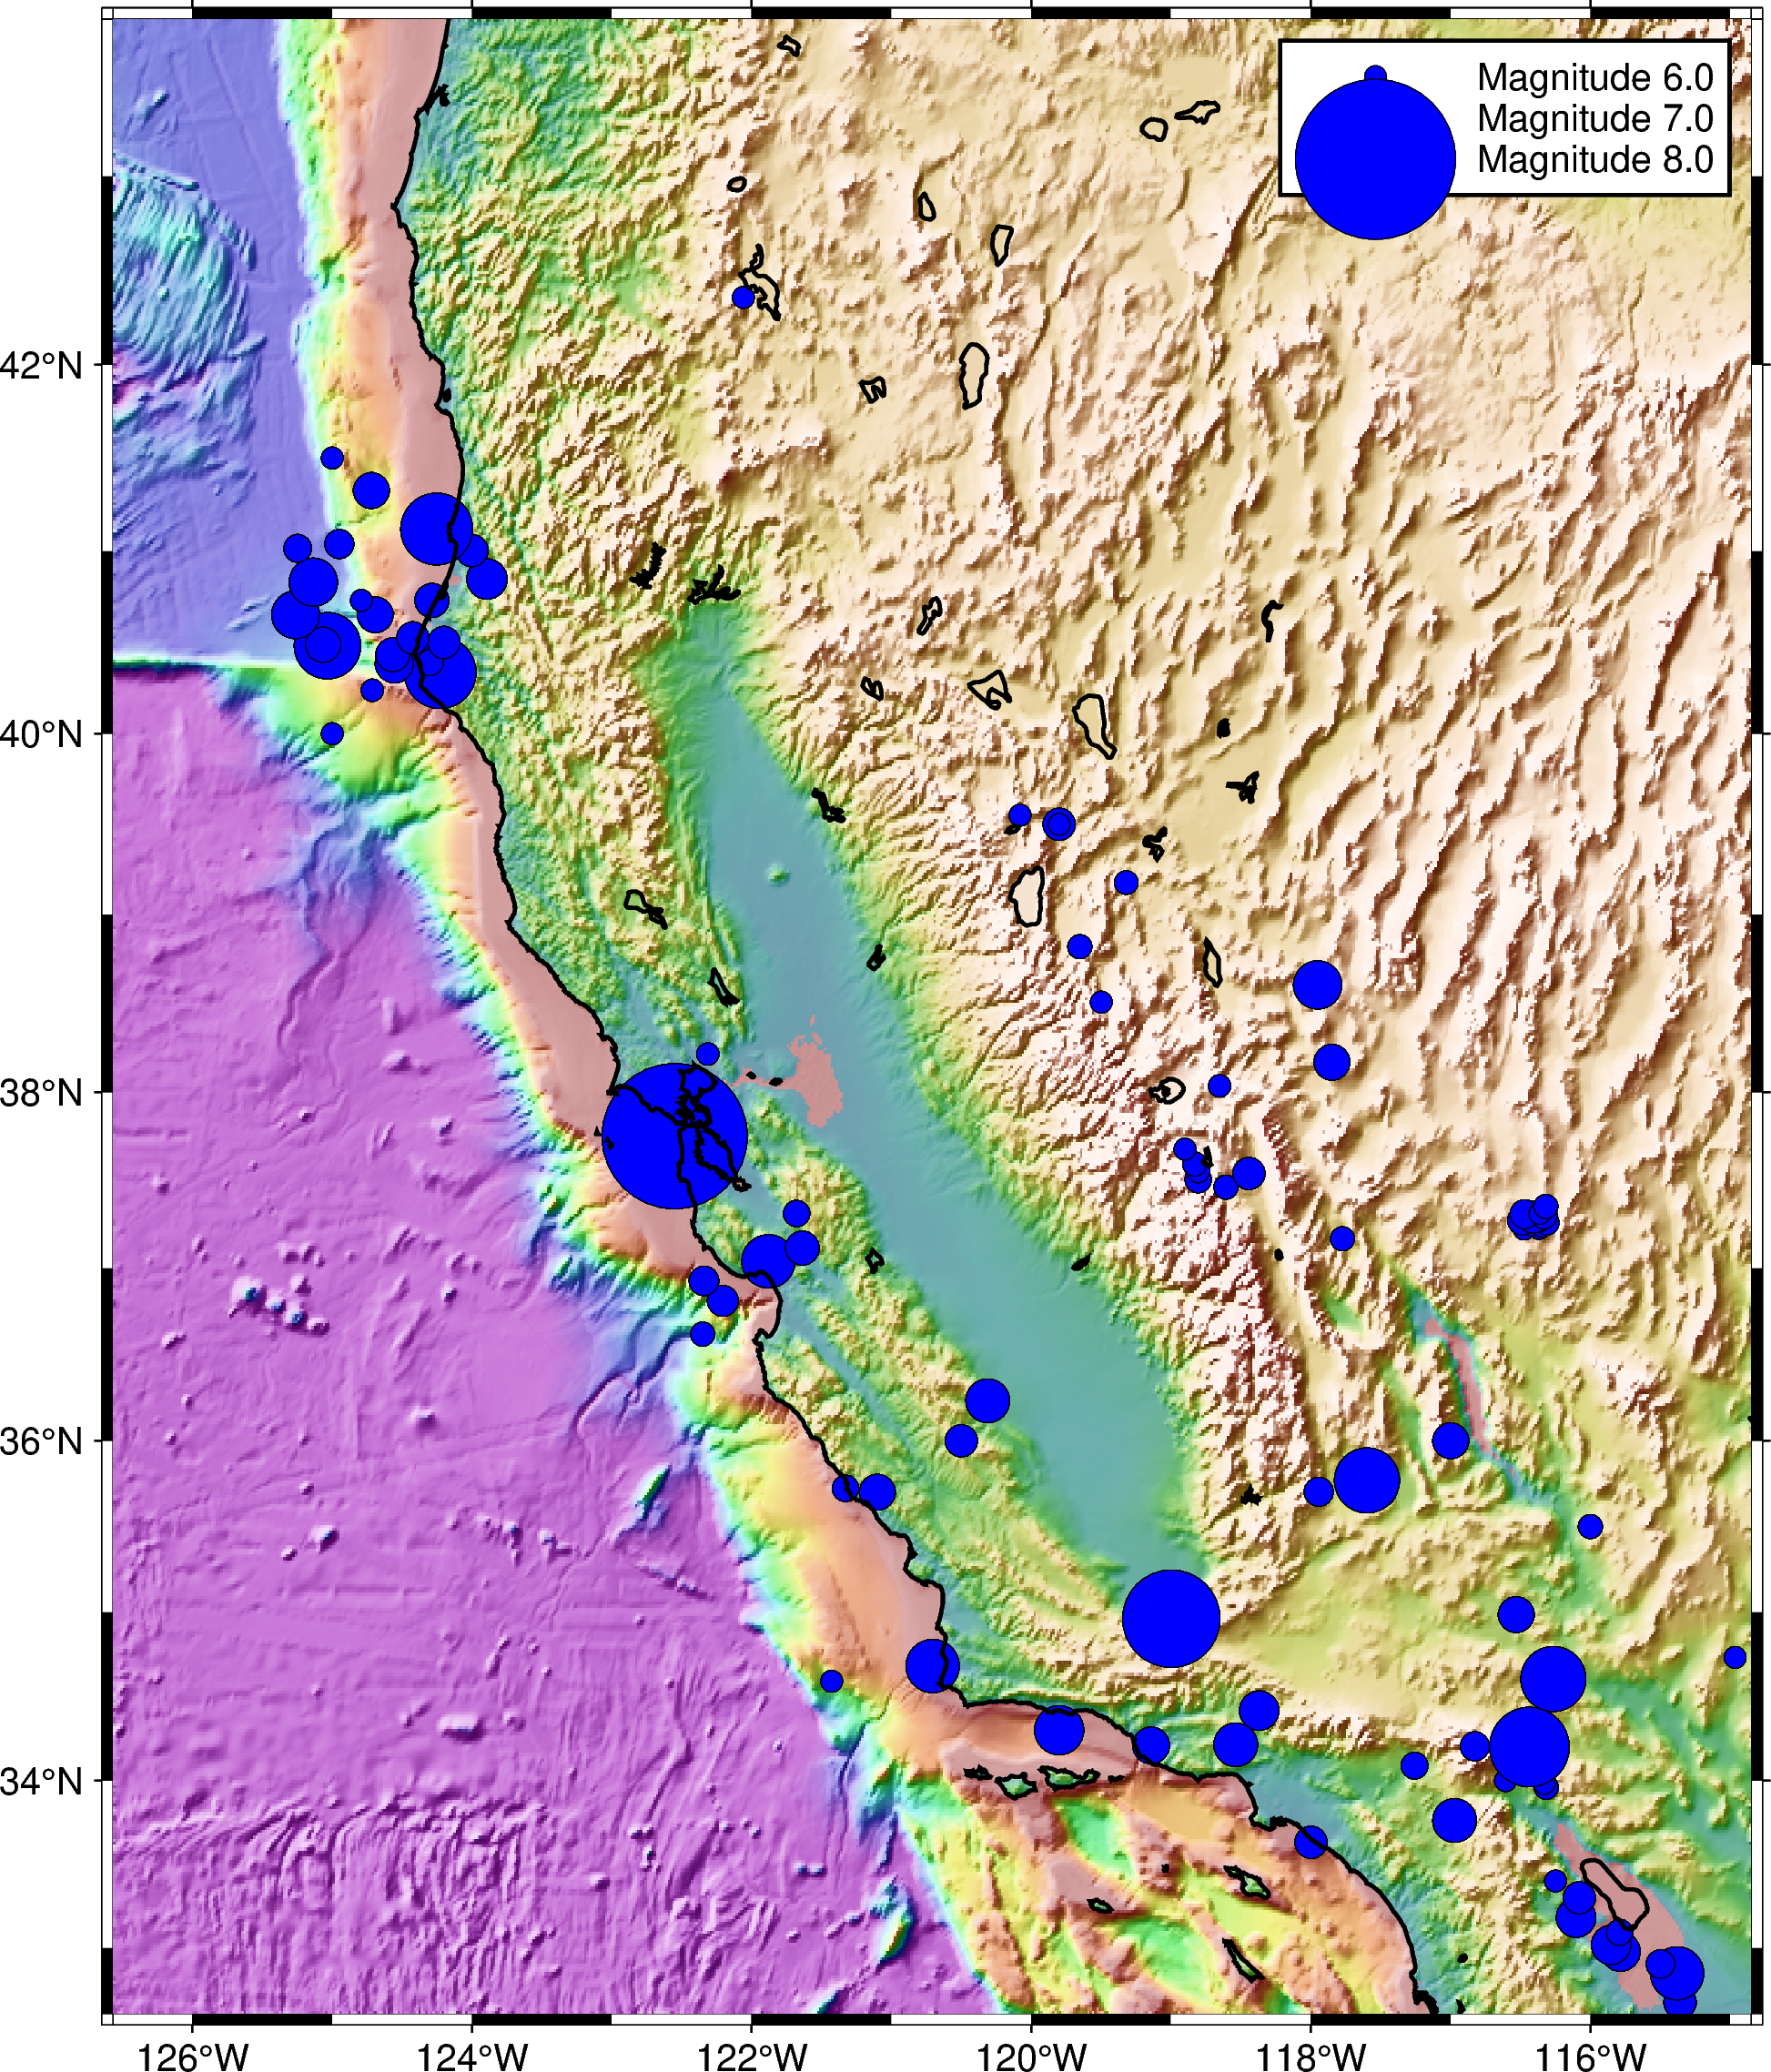

In [76]:
''' use pyGMT to plot the same figure '''

import pygmt

fig = pygmt.Figure()

fig.basemap(region=extent, projection="M6i", frame=True)
fig.grdimage(grid=topo_bathy_path, cmap="topo", shading=True)
# add earthquakes
fig.plot(
    x=ca_earthquakes_gdf.longitude,
    y=ca_earthquakes_gdf.latitude,
    size=np.exp(ca_earthquakes_gdf.mag)/2000,
    style="c",
    pen='0.2p,black',
    fill = 'blue',
    transparency = 50, # idk why this doesn't work, but im sure im right
    label = f"Magnitude 6.0+S{np.exp(6)/2000}c",
)
fig.plot(
    x=ca_earthquakes_gdf.longitude,
    y=ca_earthquakes_gdf.latitude,
    size=np.exp(ca_earthquakes_gdf.mag)/2000,
    style="c",
    pen='0.2p,black',
    fill = 'blue',
    transparency = 50, # idk why this doesn't work, but im sure im right
    label = f"Magnitude 7.0+S{np.exp(7)/2000}c",
)
fig.plot(
    x=ca_earthquakes_gdf.longitude,
    y=ca_earthquakes_gdf.latitude,
    size=np.exp(ca_earthquakes_gdf.mag)/2000,
    style="c",
    pen='0.2p,black',
    fill = 'blue',
    transparency = 50, # idk why this doesn't work, but im sure im right
    label = f"Magnitude 8.0+S{np.exp(8)/2000}c",
)
fig.legend(transparency=50)
# add costlines
fig.coast(shorelines="1p,black")
fig.show()
